In [ ]:
# | default_exp data_preprocessing

# Data Preprocessing

> In this section, we will process our dataset before passing to the modelling phase.


In [ ]:
# |export
import pandas as pd
import numpy as np
import holidays
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from nbdev.showdoc import *

## Load datasets

We're developing a function that will load a csv data file and return a "pandas" DataFrame. An error will be thrown by the function if the path is incorrect or the file is empty.

In [ ]:
# |export
def load_data(path):
    """Load a dataframe."""
    if isinstance(path, (str, Path)):
        df = pd.read_csv(path)
        if df.empty:
            raise ValueError("DataFrame Is empty")
    else:
        raise ValueError("Check your data path")
    return df

In [ ]:
# train dataset path
path_train = "./Data/facebook_train.csv"
# test dataset path
path_test = "./Data/facebook_test_no_target.csv"
# train data
Xy_train = load_data(path_train)
# test data
X_test = load_data(path_test)

## Data example

In [ ]:
Xy_train.head()

,CampaignTitle,Sector,Results,Coverage,Impressions,USD spent,StartDate,EndDate,Objetive
0,Liberta Voyages - Engagement avec une publicat...,Travel,214,1296,1328,1.45,2018-11-09,2018-11-17,Interaction
1,Liberta Voyages - Engagement avec une publicat...,Travel,931,4220,4299,1.22,2018-11-09,2018-11-17,Interaction
2,Publication : ‎« ‎الحمد لله و الصلاة و السلام ...,Travel,120,32321,46095,15.98,2018-12-06,2018-12-11,Messages
3,Publication : ‎« ‎ليبرتا تجمّد الأسعار للموسم ...,Travel,195,54121,80225,20.00,2018-12-06,2018-12-11,Messages
4,[09/11/2018] Promotion de Testour,Travel,520,15340,28771,7.73,2018-12-07,2018-12-11,Mentions J’aime une Page


Here, we must decide the nature of our outputs before continuing to the modeling stage (target values). There are two choices available to us. The first is to predict integer values, which requires the addition of a particular function, like the Poisson distribution, to the final layer of a neural network model. The second technique involves applying a log function to convert our target variables to double in order to produce variables that are simpler to model.

We are developing up a Python class called "TransformCampaign" to apply data preprocessing and some data engineering.Due to “BaseEstimator" and "TransformerMixin", this class can be used throughout data pipelines and apply fit and transform functions.

Several functions that will aid in data processing are being implemented in this class. The first is the "OneHot" Encoder, which converts categorical features to numeric. Additionally, we are making use of the two date columns (Start date and end Date) that we have by extracting the campaign's duration, determining the number of weekends during this time, considering any holidays (we have only considered Tunisian Holidays), determining the season and finally, converting the target values to a decimal format using the log function.

# Transformer

In [ ]:
# |export
class TransformCampaign(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Constructor"""
        self.ohe = OneHotEncoder()
        self.categorical_cols = ["Sector", "Objetive", "Season"]

    def fit(self, X: pd.DataFrame, y=None):
        """fit function to prepare data"""
        X_ = X.copy()
        return self

    def number_of_weekends(self, startDate: datetime, endDate: datetime) -> int:
        """determine how many weekends there are in a particular timeframe."""
        duration = (endDate - startDate).days + 1
        date_list = [startDate + timedelta(days=x) for x in range(duration)]
        week_end_days = 0
        for date in date_list:
            if date.weekday() > 4:
                week_end_days = week_end_days + 1
        return week_end_days

    def is_holiday(self, starDate: datetime, endDate: datetime, endDateYear: int):
        """check whether there are any holidays at a specific time period."""
        holi_days = []
        for date, name in sorted(holidays.TN(years=endDateYear).items()):
            holi_days.append({"date": date, "holiday": name})
        holi_days = pd.DataFrame(holi_days)
        holi_days["date"] = pd.to_datetime(holi_days["date"])
        number_of_holidays = 0
        for _, row in holi_days.iterrows():
            date = row["date"]
            if starDate <= date <= endDate:
                number_of_holidays = number_of_holidays + 1
        return int(number_of_holidays > 0)

    def season_of_date(self, date):
        """determine the season of a given date"""
        year = str(date.year)
        seasons = {
            "spring": pd.date_range(start="21-03-" + year, end="20-06-" + year),
            "summer": pd.date_range(start="21-06-" + year, end="22-09-" + year),
            "autumn": pd.date_range(start="23-09-" + year, end="20-12-" + year),
        }
        if date in seasons["spring"]:
            return "spring"
        if date in seasons["summer"]:
            return "summer"
        if date in seasons["autumn"]:
            return "autumn"
        else:
            return "winter"

    def transform(self, X: pd.DataFrame, y=None, data_type="train"):
        """transform data and create new features"""
        X_ = X.copy()
        # 1. Extract new features from dates
        # convert startDate and EndDate to a date format
        X_.StartDate = pd.to_datetime(X_.StartDate)
        X_.EndDate = pd.to_datetime(X_.EndDate)
        # extract year from dates
        X_["StartDateYear"] = X_.StartDate.apply(lambda d: d.year)
        X_["EndDateYear"] = X_.EndDate.apply(lambda d: d.year)
        # extract duration
        X_["duration"] = (X_["EndDate"] - X_["StartDate"]).dt.days
        # extract if thr's a holiday
        X_["Holidays"] = X_.apply(
            lambda campaign: self.is_holiday(
                campaign["StartDate"], campaign["EndDate"], campaign["EndDateYear"]
            ),
            axis=1,
        )
        # number of weekends
        X_["NumberOfWeekends"] = X_.apply(
            lambda campaign: self.number_of_weekends(
                campaign["StartDate"], campaign["EndDate"]
            ),
            axis=1,
        )
        # Season
        X_["Season"] = X_.apply(
            lambda campaign: self.season_of_date(campaign["StartDate"])
            + "-"
            + self.season_of_date(campaign["EndDate"]),
            axis=1,
        )
        # delete title, date columns
        X_.drop(
            ["CampaignTitle", "StartDate", "EndDate", "StartDateYear", "EndDateYear"],
            axis=1,
            inplace=True,
            errors="ignore",
        )
        # 2. encode categorical variables
        if data_type == "train":
            self.ohe.fit(X_.loc[:, self.categorical_cols])
        catego_sparse = self.ohe.transform(X_.loc[:, self.categorical_cols])
        catego_encoded = catego_sparse.toarray()
        features = self.ohe.get_feature_names_out(self.categorical_cols)
        df_catego_encoded = pd.DataFrame(
            catego_encoded, index=X_.index, columns=features
        )
        X_ = pd.concat([X_, df_catego_encoded], axis=1)
        X_.drop(self.categorical_cols, axis=1, inplace=True, errors="ignore")
        # 3. transform target values to double by applying log function
        if "Results" in X_.columns:
            # eliminate outliers
            # max and min threshold for results
            max_th_r = X_["Results"].quantile(0.95)
            min_th_r = X_["Results"].quantile(0.05)
            X_ = X_[(X_.Results < max_th_r) & (X_.Results > min_th_r)]
            # max and min threshold for Coverage
            max_th_c = X_["Coverage"].quantile(0.95)
            min_th_c = X_["Coverage"].quantile(0.05)
            X_ = X_[(X_.Coverage < max_th_c) & (X_.Coverage > min_th_c)]
            # max and min threshold for Impressions
            max_th_i = X_["Impressions"].quantile(0.95)
            min_th_i = X_["Impressions"].quantile(0.05)
            X_ = X_[(X_.Impressions < max_th_i) & (X_.Impressions > min_th_i)]
            # divide by Usd spent
            X_["Results"] = X_["Results"] / X_["USD spent"]
            X_["Coverage"] = X_["Coverage"] / X_["USD spent"]
            X_["Impressions"] = X_["Impressions"] / X_["USD spent"]
            # apply log
            X_["Results"] = X_["Results"].apply(lambda r: 0 if r <= 0 else np.log2(r))
            X_["Coverage"] = X_["Coverage"].apply(lambda c: 0 if c <= 0 else np.log2(c))
            X_["Impressions"] = X_["Impressions"].apply(
                lambda i: 0 if i <= 0 else np.log2(i)
            )

        return X_

# Call Transformer

In [ ]:
trsf = TransformCampaign()
X_trsf = trsf.fit_transform(Xy_train)

In [ ]:
X_trsf.head()

,Results,Coverage,Impressions,USD spent,duration,Holidays,NumberOfWeekends,Sector_Automotive,Sector_B2B,Sector_Ecommerce & Retail,...,Objetive_Messages,Objetive_Trafic,Season_autumn-autumn,Season_autumn-winter,Season_spring-spring,Season_spring-summer,Season_summer-autumn,Season_summer-summer,Season_winter-spring,Season_winter-winter
2,2.908695,10.981989,11.494127,15.98,5,0,2,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.285402,11.401973,11.969836,20.00,5,0,2,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.071899,10.954542,11.861859,7.73,4,0,2,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.605130,10.104277,10.779776,64.94,12,0,4,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.219358,11.191053,11.278774,4.08,1,0,0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Target Values Distribution after Transformations

We exhibit the distribution of the target values before to applying the mentioned transformation (second option).

## Coverage Output

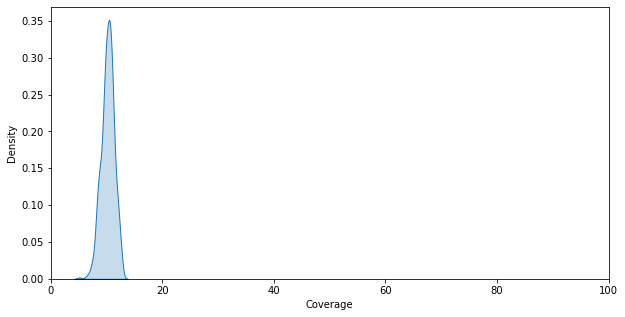

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 100)
plt.xlabel("Coverage")
plt.ylabel("Density")
sns.kdeplot(X_trsf["Coverage"], shade=True)
plt.show()

## Results Output

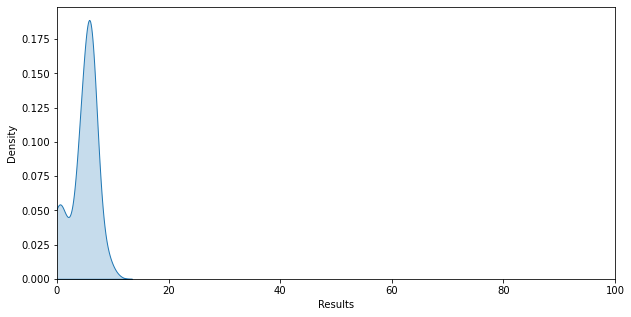

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 100)
plt.xlabel("Results")
plt.ylabel("Density")
sns.kdeplot(X_trsf["Results"], shade=True)
plt.show()

## Impressions Output

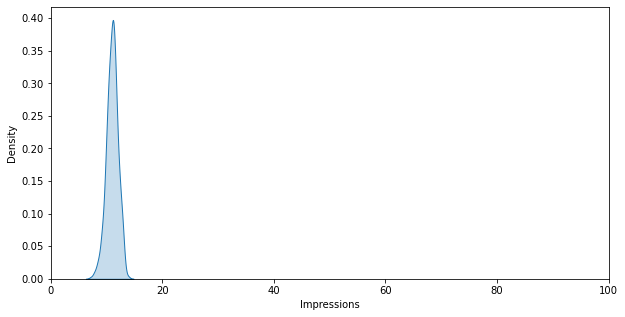

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 100)
plt.xlabel("Impressions")
plt.ylabel("Density")
sns.kdeplot(X_trsf["Impressions"], shade=True)
plt.show()